In [1]:
import desispec.io

import numpy as np
from   glob import glob
import pandas as pd
import pylab as pl
from   tqdm.notebook import tqdm
import os
import argparse
from   astropy.table import Table, vstack, join

from desitarget.sv3 import sv3_targetmask    # For SV3

from src.ccatalog import create

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument("-r", "--release", help="DESI Release")
# parser.add_argument("-s", "--survey", help="Survey")
# parser.add_argument("-c", "--clss", help="Class (bgs,...)")
# parser.add_argument("-o", "--overwrite", help="Continue compilation y/n")
# args = parser.parse_args()

# release   = args.release
# survey    = args.survey
# clss      = args.clss
# overwrite = args.orverwrite

In [3]:
release   = 'fuji'
survey    = 'sv3'
clss      = 'bgs'
overwrite = 'yes'

release_dir = desispec.io.specprod_root(release)

#- Read the exposures files
expo_data = Table.read(f'{release_dir}/exposures-{release}.fits', hdu='EXPOSURES')
expo_data = expo_data[expo_data['SURVEY']==survey]
expo_data = expo_data[(expo_data['PROGRAM']=='bright') | (expo_data['PROGRAM']=='dark')]

nights = expo_data['NIGHT']
tiles  = expo_data['TILEID']

In [4]:
#- Read the zpix files
zpix_cat = Table.read(f'{release_dir}/zcatalog/zall-pix-{release}.fits', hdu="ZCATALOG")

#- Define bgs, brigh and dark filters
is_bgs    = zpix_cat['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['BGS_ANY'] != 0
# print(sum(is_bgs))
is_bright = zpix_cat['PROGRAM'] == 'bright'
is_dark   = zpix_cat['PROGRAM'] == 'dark'

#- Select  bgs and brigh|dark 
targetids = zpix_cat[is_bgs & (is_bright | is_dark)]['TARGETID']
zpix      = zpix_cat[is_bgs & (is_bright | is_dark)]['Z']

In [5]:
df_targetids = pd.DataFrame({'TARGETID': pd.Series(targetids, dtype='int'),
                             'ZPIX'    : pd.Series(zpix, dtype='float')
                            })
df_targetids

TARGETID      ZPIX
0       39632936147880659  0.212324
1       39632936152072293  0.175118
2       39632936152073395  0.344582
3       39632936147880778  0.212030
4       39632936147880919  0.179103
...                   ...       ...
278475  39628438591505450  0.427184
278476  39628433243767283  0.415335
278477  39628438591507485  0.347490
278478  39628438591507269  0.428623
278479  39628433243767166  0.510809

[278480 rows x 2 columns]

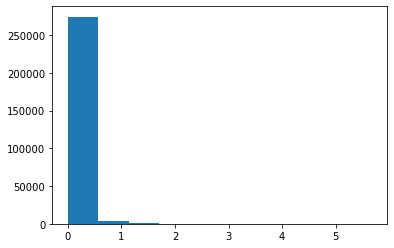

In [6]:
_ = pl.hist(df_targetids['ZPIX'])

In [7]:
df_targetids = df_targetids[~df_targetids['TARGETID'].duplicated()]

In [8]:
#- Define targets from VAC
vac_path = '/global/cfs/cdirs/desi/public/edr/vac'
columns_spec = ['TARGETID','CONTINUUM_Z'] # 'Z','Z_RR','RA','DEC'
columns_photo = ['TARGETID','LOGL_5100','LOGMSTAR','ABSMAG_U','ABSMAG_B','ABSMAG_V',
                 'ABSMAG_SDSS_U','ABSMAG_SDSS_G','ABSMAG_SDSS_R','ABSMAG_SDSS_I','ABSMAG_SDSS_Z']

In [9]:
spec_bright = Table.read(f'{vac_path}/fastspecfit/{release}/v1.0/catalogs/fastspec-{release}-{survey}-bright.fits', hdu='FASTSPEC')[columns_spec]
spec_dark   = Table.read(f'{vac_path}/fastspecfit/{release}/v1.0/catalogs/fastspec-{release}-{survey}-dark.fits', hdu='FASTSPEC')[columns_spec]
# spec_keys = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-bright.fits', hdu='FASTSPEC').keys()
spec = vstack([spec_bright, spec_dark])
del spec_bright, spec_dark

phot_bright = Table.read(f'{vac_path}/fastspecfit/{release}/v1.0/catalogs/fastphot-{release}-{survey}-bright.fits', hdu=1)[columns_photo]
phot_dark   = Table.read(f'{vac_path}/fastspecfit/{release}/v1.0/catalogs/fastphot-{release}-{survey}-dark.fits', hdu=1)[columns_photo]
# phot_keys = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-bright.fits', hdu='FASTPHOT').keys()
phot = vstack([phot_bright, phot_dark])
del phot_bright, phot_dark

phys_targets = join(spec, phot, keys=['TARGETID']).to_pandas()
del spec, phot

#- Apply filter to remove empty data
phys_targets = phys_targets[(phys_targets['ABSMAG_B'] != 0) & (phys_targets['ABSMAG_U'] != 0) & (phys_targets['ABSMAG_V'] != 0)]
print(len(phys_targets))

884796


In [10]:
phys_targets

TARGETID  CONTINUUM_Z  LOGL_5100   LOGMSTAR   ABSMAG_U  \
10        933756462432256     1.628024   1.472690  10.337196 -23.802223   
13        933769162784768     1.040732   1.440602  11.993400 -20.859251   
14        933781254963200     1.032157   1.773547  12.470922 -21.890516   
15        933787294760960     1.023777   1.705714  12.387120 -21.867088   
16        933792650887169     1.546646   1.333789  10.746200 -22.974958   
...                   ...          ...        ...        ...        ...   
892911  43977515642913243     0.217875   0.242375  10.820901 -19.980917   
892912  43977515642913243     0.217875   0.242247  10.820842 -19.980585   
892919  43977534898962797     0.249658  -1.384234   8.422338 -15.678617   
892920  43977540913594618     0.715534   0.559908  10.989570 -20.798077   
892921  43977540930371976     0.115302  -1.204636   7.063594 -17.742910   

         ABSMAG_B   ABSMAG_V  ABSMAG_SDSS_U  ABSMAG_SDSS_G  ABSMAG_SDSS_R  \
10     -24.082235 -24.247213     -23.696012     -24.045326     -24.261436   
13     -23.752394 -24.554939     -20.347025     -23.625374     -24.623617   
14     -24.918499 -25.818153     -21.344917     -24.780993     -25.895555   
15     -24.735289 -25.624130     -21.325115     -24.598967     -25.700573   
16     -23.786617 -23.848297     -22.636621     -23.708153     -23.854128   
...           ...        ...            ...            ...            ...   
892911 -20.672430 -21.265778     -19.886524     -20.587589     -21.324942   
892912 -20.672096 -21.265474     -19.886204     -20.587255     -21.324640   
892919 -16.591030 -17.121281     -15.311108     -16.489010     -17.167927   
892920 -21.596571 -21.912733     -20.473434     -21.505341     -21.969151   
892921 -17.697258 -17.086823     -17.812378     -17.707283     -17.058348   

        ABSMAG_SDSS_I  ABSMAG_SDSS_Z  
10         -24.317596     -24.316866  
13         -24.996452     -25.249964  
14         -26.343403     -26.654007  
15         -26.140066     -26.444305  
16         -23.830608     -23.823208  
...               ...            ...  
892911     -21.658300     -21.900042  
892912     -21.658010     -21.899755  
892919     -17.643911     -17.870012  
892920     -22.282572     -22.510868  
892921     -16.791740     -16.552849  

[884796 rows x 12 columns]

In [ ]:
# Match with bgs targets
print(len(phys_targets))
phys_targets = pd.merge(phys_targets, df_targetids, on=['TARGETID'])
print(len(phys_targets))
#- Remove duplicated entries
phys_targets = phys_targets.drop_duplicates()
print(len(phys_targets))

pbar_night = tqdm(total=len(nights), desc=f'{survey}')
for night, tile in zip(nights, tiles):
    create(release, survey, clss, phys_targets, night, tile, overwrite)
    pbar_night.update()
pbar_night.close()

884796
307338
307336


sv3:   0%|          | 0/662 [00:00<?, ?it/s]

INFO:spectra.py:285:read_spectra: iotime 1.194 sec to read spectra-3-393-20210419.fits at 2022-10-19T00:44:41.330939
INFO:spectra.py:285:read_spectra: iotime 1.337 sec to read spectra-4-393-20210419.fits at 2022-10-19T00:46:25.468019
INFO:spectra.py:285:read_spectra: iotime 1.254 sec to read spectra-5-393-20210419.fits at 2022-10-19T00:53:10.815729
INFO:spectra.py:285:read_spectra: iotime 1.208 sec to read spectra-6-393-20210419.fits at 2022-10-19T00:59:05.173086
INFO:spectra.py:285:read_spectra: iotime 1.096 sec to read spectra-7-393-20210419.fits at 2022-10-19T01:04:17.742878
INFO:spectra.py:285:read_spectra: iotime 1.230 sec to read spectra-8-393-20210419.fits at 2022-10-19T01:10:43.168501
INFO:spectra.py:285:read_spectra: iotime 1.095 sec to read spectra-9-393-20210419.fits at 2022-10-19T01:19:26.335638
INFO:spectra.py:285:read_spectra: iotime 1.126 sec to read spectra-0-368-20210419.fits at 2022-10-19T01:27:10.004808
INFO:spectra.py:285:read_spectra: iotime 1.088 sec to read spect

In [ ]:
_= pl.hist(phys_targets['CONTINUUM_Z'])

In [ ]:
sum(phys_targets['CONTINUUM_Z']>0.5)